# Home Credit Default Risk

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

## Data

The data can be accessed from [here](https://www.kaggle.com/c/home-credit-default-risk/data)

There are totally 9 datasets: train and test datasets, 6 additional datasets that contain clients previous information and records and one file `HomeCredit_columns_description.csv` that contains descriptions of the columns in the various data files.

![](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import gc
from datetime import date
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
app_train=pd.read_csv('../input/application_train.csv')
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
bureau=pd.read_csv('../input/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [4]:
bureau_balance=pd.read_csv('../input/bureau_balance.csv')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [5]:
credit_card_balance=pd.read_csv('../input/credit_card_balance.csv')
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [6]:
installments_payments=pd.read_csv('../input/installments_payments.csv')
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [7]:
pos_cash=pd.read_csv('../input/POS_CASH_balance.csv')
pos_cash.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [8]:
previous_application=pd.read_csv('../input/previous_application.csv')
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


### Combine train and test

In [9]:
app_test=pd.read_csv('../input/application_test.csv')

Y=app_train['TARGET']
train_X=app_train.drop(columns=['TARGET'])
test_X=app_test
test_ID=app_test['SK_ID_CURR']

train_X['train']=1
train_X['test']=0
test_X['train']=0
test_X['test']=1

all_data=pd.concat([train_X,test_X],axis=0)

all_data['NEW_CREDIT_TO_ANNUITY_RATIO'] = all_data['AMT_CREDIT'] / all_data['AMT_ANNUITY']
all_data['NEW_CREDIT_TO_GOODS_RATIO'] = all_data['AMT_CREDIT'] / all_data['AMT_GOODS_PRICE']

bin_cols=['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
all_data[bin_cols]=all_data[bin_cols].apply(lambda x: pd.factorize(x)[0])


del app_train, app_test, train_X, test_X

## Feature engineering

This is the most important part in order to get good classification result. I learn a lot from [olivier's kaggle kernel](https://www.kaggle.com/ogrellier/lighgbm-with-selected-features), and really get inspired by how to deal with such problem that have multiple data files.

Since each of the six files are connected to the train|test dataset on the one column `SK_ID_CURR`, the basic idea is to aggregate all the selected features per `SK_ID_CURR` using groupby function, then join with the train|test data.

Therefor, all the categorical data in the six files should be transformed using one hot encoding in order to apply aggregation, since label encoding would not make sense (mean, max, min, etc.).

### Create dummy variables for categorical data

In [10]:
def get_categorical_features(df):
    feats = [col for col in list(df.columns) if df[col].dtype == 'object']
    return feats

def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    df=pd.get_dummies(df)
    new_columns=[c for c in df.columns if c not in original_columns]
    return df, new_columns

In [11]:
bureau,bureau_cat=one_hot_encoder(bureau)
bureau_balance,bb_cat=one_hot_encoder(bureau_balance)
credit_card_balance,credit_cat=one_hot_encoder(credit_card_balance)
installments_payments,inst_cat=one_hot_encoder(installments_payments)
pos_cash,pos_cat=one_hot_encoder(pos_cash)
previous_application,prev_cat=one_hot_encoder(previous_application)

In [12]:
# bureau=pd.get_dummies(bureau,drop_first=True)
# credit_card_balance=pd.get_dummies(credit_card_balance,drop_first=True)
# # installments_payments=pd.get_dummies(installments_payments,drop_first=True)
# pos_cash=pd.get_dummies(pos_cash,drop_first=True)
# previous_application=pd.get_dummies(previous_application,drop_first=True)

In [13]:
print('bureau',bureau.shape)
print('bureau_balance',bureau_balance.shape)
print('credit_card_balance',credit_card_balance.shape)
print('installments_payments',installments_payments.shape)
print('pos_cash',pos_cash.shape)
print('previous_application',previous_application.shape)

bureau (1716428, 37)
bureau_balance (27299925, 10)
credit_card_balance (3840312, 29)
installments_payments (13605401, 8)
pos_cash (10001358, 16)
previous_application (1670214, 164)


 ### Bureau & Bureau Balance

In [14]:
bb_aggregations={'MONTHS_BALANCE': ['min','max','size']}
for col in bb_cat:
    bb_aggregations[col]=['mean']
    
bb_agg=bureau_balance.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns=['_'.join(x) for x in bb_agg.columns.tolist()]

bureau=bureau.merge(bb_agg,how='left',on='SK_ID_BUREAU')

del bureau_balance, bb_agg

In [15]:
bureau_aggregations={
    'DAYS_CREDIT': ['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['max','mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'MONTHS_BALANCE_min': ['min'],
    'MONTHS_BALANCE_max': ['max'],
    'MONTHS_BALANCE_size': ['mean', 'sum']
}
for cat in bureau_cat: 
    bureau_aggregations[cat]=['mean']
for cat in bb_cat: 
    bureau_aggregations[cat + '_mean']=['mean']
    
bureau_agg = bureau.groupby('SK_ID_CURR').agg(bureau_aggregations)
bureau_agg.columns=['b_'+'_'.join(x) for x in bureau_agg.columns.tolist()]

all_data=all_data.merge(bureau_agg.reset_index(),how='left',on='SK_ID_CURR')


In [16]:
print('bureau shape: ', bureau_agg.shape)
del bureau, bureau_agg
gc.collect()

bureau shape:  (305811, 58)


130

In [17]:
# bureau_avg=bureau.groupby('SK_ID_CURR').mean()
# bureau_avg['SK_ID_BUREAU_count']=bureau[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
# bureau_avg=bureau_avg.drop(columns=['SK_ID_BUREAU'])
# bureau_avg.columns=['b_' + col for col in bureau_avg.columns]

### Credit Card Balance

In [18]:
credit_card_balance=credit_card_balance.drop(columns=['SK_ID_PREV'])
credit_agg=credit_card_balance.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum'])
credit_agg.columns=['c_'+'_'.join(x) for x in credit_agg.columns.tolist()]
credit_agg['c_size']=credit_card_balance.groupby('SK_ID_CURR').size()

all_data=all_data.merge(credit_agg.reset_index(),how='left',on='SK_ID_CURR')


In [19]:
print('credit card balance shape: ', credit_agg.shape)
del credit_card_balance, credit_agg
gc.collect()

credit card balance shape:  (103558, 109)


56

In [20]:
# credit_avg=credit_card_balance.groupby('SK_ID_CURR').mean()
# credit_avg['SK_ID_PREV_count']=credit_card_balance[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()['SK_ID_PREV']
# credit_avg=credit_avg.drop(columns=['SK_ID_PREV'])
# credit_avg.columns=['c_' + col for col in credit_avg.columns]

### Installments Payments

In [21]:
installments_payments['PAYMENT_RATIO']=installments_payments['AMT_PAYMENT'] / installments_payments['AMT_INSTALMENT']

inst_aggregations={
    'PAYMENT_RATIO': ['max', 'mean', 'sum', 'var'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum'],
    'DAYS_INSTALMENT': ['max', 'mean', 'sum']
}

inst_agg=installments_payments.groupby('SK_ID_CURR').agg(inst_aggregations)
inst_agg.columns=['i_'+'_'.join(x) for x in inst_agg.columns.tolist()]

all_data=all_data.merge(inst_agg.reset_index(),how='left',on='SK_ID_CURR')


In [22]:
# inst_avg=installments_payments.groupby('SK_ID_CURR').mean()
# inst_avg['SK_ID_PREV_count']=installments_payments[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()['SK_ID_PREV']
# inst_avg=inst_avg.drop(columns=['SK_ID_PREV'])
# inst_avg.columns=['i_' + col for col in inst_avg.columns]

In [23]:
print('installments payments shape: ', inst_agg.shape)
del installments_payments, inst_agg
gc.collect()

installments payments shape:  (339587, 17)


49

### Pos Cash Balance

In [24]:
pos_aggregations={
    'MONTHS_BALANCE': ['max', 'mean','sum'],
    'SK_DPD': ['min','max', 'mean'],
    'SK_DPD_DEF': ['min','max', 'mean']
}
for cat in pos_cat:
    pos_aggregations[cat]=['mean']
    
pos_agg = pos_cash.groupby('SK_ID_CURR').agg(pos_aggregations)
pos_agg.columns=['pos_'+'_'.join(x) for x in pos_agg.columns.tolist()]
pos_agg['pos_size']=pos_cash.groupby('SK_ID_CURR').size()

all_data=all_data.merge(pos_agg.reset_index(),how='left',on='SK_ID_CURR')


In [25]:
# pos_avg=pos_cash.groupby('SK_ID_CURR').mean()
# pos_avg['SK_ID_PREV_count']=pos_cash[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()['SK_ID_PREV']
# pos_avg=pos_avg.drop(columns=['SK_ID_PREV'])
# pos_avg.columns=['pos_' + col for col in pos_avg.columns]

In [26]:
print('Pos Cash Balance shape: ', pos_agg.shape)
del pos_cash, pos_agg
gc.collect()

Pos Cash Balance shape:  (337252, 19)


42

### Previous Applications

In [27]:
previous_application['APP_CREDIT_RATIO']=previous_application['AMT_APPLICATION'] / previous_application['AMT_CREDIT']
prev_aggregations={
    'APP_CREDIT_RATIO': ['min', 'max', 'mean'],
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum']
}
for cat in prev_cat:
    prev_aggregations[cat]=['mean']
    
prev_agg=previous_application.groupby('SK_ID_CURR').agg(prev_aggregations)
prev_agg.columns=['prev_'+'_'.join(x) for x in prev_agg.columns.tolist()]
prev_agg['prev_size']=previous_application.groupby('SK_ID_CURR').size()

all_data=all_data.merge(prev_agg.reset_index(),how='left',on='SK_ID_CURR')


In [28]:
# prev_app_avg=previous_application.groupby('SK_ID_CURR').mean()
# prev_app_avg['SK_ID_PREV_count']=previous_application[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()['SK_ID_PREV']
# prev_app_avg=prev_app_avg.drop(columns=['SK_ID_PREV'])
# prev_app_avg.columns=['prev_' + col for col in prev_app_avg.columns]

In [29]:
print('previous applications shape: ', prev_agg.shape)
del previous_application, prev_agg
gc.collect()

previous applications shape:  (338857, 173)


91

## Lightgbm model

In [30]:
# all_data=all_data.merge(bureau_agg.reset_index(),how='left',on='SK_ID_CURR')
# all_data=all_data.merge(credit_agg.reset_index(),how='left',on='SK_ID_CURR')
# all_data=all_data.merge(inst_agg.reset_index(),how='left',on='SK_ID_CURR')
# all_data=all_data.merge(pos_agg.reset_index(),how='left',on='SK_ID_CURR')
# all_data=all_data.merge(prev_agg.reset_index(),how='left',on='SK_ID_CURR')


In [31]:
all_data=pd.get_dummies(all_data,drop_first=True)

In [32]:
drop_cols=['SK_ID_CURR','train','test']
keep_cols=[col for col in all_data.columns if col not in drop_cols]

train_X=all_data[all_data['train']==1][keep_cols]
test_X=all_data[all_data['test']==1][keep_cols]

del all_data
gc.collect()

112

In [33]:
from sklearn.model_selection import train_test_split 
import lightgbm as lgb

In [34]:
x_train, x_val, y_train, y_val = train_test_split(train_X, Y, test_size=0.3, random_state=33)

lgb_train=lgb.Dataset(data=x_train,label=y_train)
lgb_val=lgb.Dataset(data=x_val,label=y_val)

In [35]:
params={'task': 'train', 
          'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'metric': 'auc', 
          'learning_rate': 0.02, 
          'num_leaves': 20, 
          'num_iteration': 5000, 
          'verbose': 0 ,
          'colsample_bytree':0.9, 
          'subsample':0.87, 
          'max_depth':8, 
          'reg_alpha':0.03, 
          'reg_lambda':0.07, 
          'min_split_gain':0.02, 
          'min_child_weight':50}

model=lgb.train(params, lgb_train, valid_sets=lgb_val, early_stopping_rounds=100, verbose_eval=200, num_boost_round=10000)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.769402
[400]	valid_0's auc: 0.780252
[600]	valid_0's auc: 0.784391
[800]	valid_0's auc: 0.785941
[1000]	valid_0's auc: 0.786879
[1200]	valid_0's auc: 0.787325
[1400]	valid_0's auc: 0.787732
[1600]	valid_0's auc: 0.788053
[1800]	valid_0's auc: 0.788301
Early stopping, best iteration is:
[1837]	valid_0's auc: 0.788356


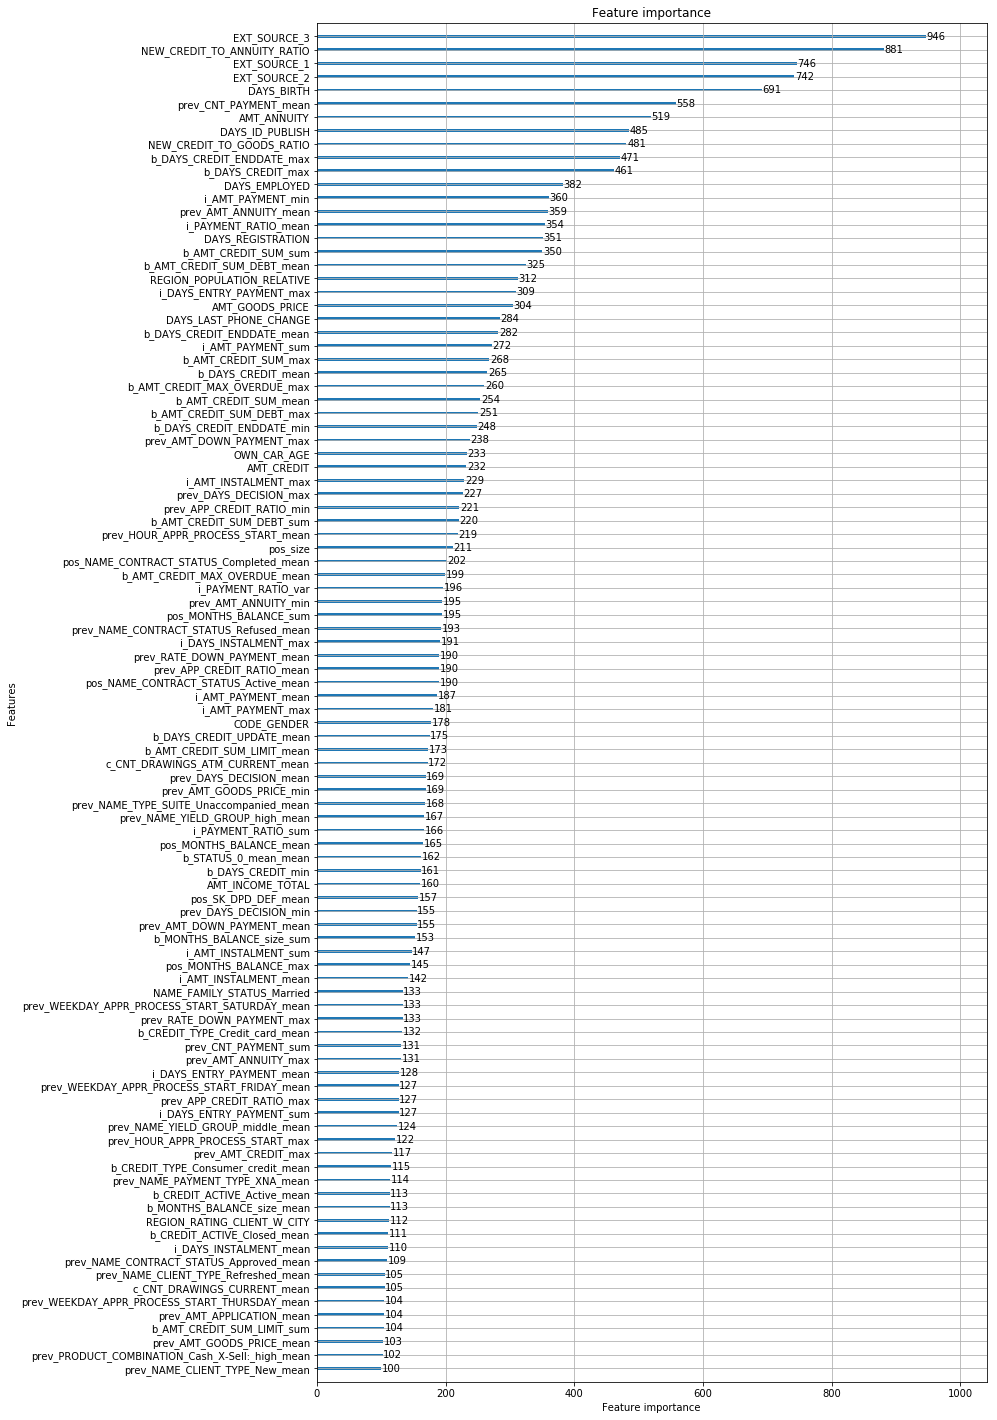

In [36]:
lgb.plot_importance(model, figsize=(12, 25), max_num_features=100);

In [38]:
pred=model.predict(test_X)
sub_lgb=pd.DataFrame({'SK_ID_CURR': test_ID, 'TARGET': pred})
sub_lgb.to_csv("lgb_baseline.csv", index=False)
sub_lgb.head()

,SK_ID_CURR,TARGET
0,100001,0.036405
1,100005,0.159590
2,100013,0.017917
3,100028,0.029811
4,100038,0.146283
